In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, MinMaxScaler,StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [2]:
data=pd.read_csv('repo_main - Sheet1 (1).csv')
data=data[::-1]
data = data.reset_index(drop=True)

rate=pd.read_csv('DFF_m - DFF (1).csv')

In [3]:
rate.head()

,observation_date,DFF
0,2018-1-1,1.33
1,2018-2-1,1.42
2,2018-3-1,1.42
3,2018-4-1,1.42
4,2018-5-1,1.42


In [4]:
data.head(5)

,Date,SOFR Fix,SOFR Volume,DTCC Tsy,RRP Amt,TGA Balance,Unnamed: 6
0,4/2/2018,1.80,849,1.950,3.823,324.262,NaN
1,4/3/2018,1.83,825,1.930,8.695,299.702,NaN
2,4/4/2018,1.74,859,1.795,4.570,300.604,NaN
3,4/5/2018,1.75,829,1.830,4.645,292.669,NaN
4,4/6/2018,1.75,845,1.819,4.895,291.637,NaN


In [5]:
data=data.dropna(axis=1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1873 entries, 0 to 1872
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         1873 non-null   object 
 1   SOFR Fix     1873 non-null   float64
 2   SOFR Volume  1873 non-null   object 
 3   DTCC Tsy     1873 non-null   float64
 4   RRP Amt      1873 non-null   float64
 5   TGA Balance  1873 non-null   float64
dtypes: float64(4), object(2)
memory usage: 87.9+ KB


In [7]:
data.shape

(1873, 6)

In [8]:
data['Date'] = pd.to_datetime(data['Date'], format='mixed', dayfirst=True, errors='coerce')
data['SOFR Volume']=pd.to_numeric(data['SOFR Volume'],errors='coerce')

rate['observation_date'] = pd.to_datetime(rate['observation_date'], format='mixed', dayfirst=True, errors='coerce')


In [9]:
rate.head()

,observation_date,DFF
0,2018-01-01,1.33
1,2018-02-01,1.42
2,2018-03-01,1.42
3,2018-04-01,1.42
4,2018-05-01,1.42


In [10]:
data.isnull().sum()

Date            0
SOFR Fix        0
SOFR Volume    14
DTCC Tsy        0
RRP Amt         0
TGA Balance     0
dtype: int64

In [11]:
data['SOFR Volume'] = data['SOFR Volume'].fillna(data['SOFR Volume'].mean())

In [12]:
data.head(20)

,Date,SOFR Fix,SOFR Volume,DTCC Tsy,RRP Amt,TGA Balance
0,2018-02-04,1.80,849.0,1.950,3.823,324.262
1,2018-03-04,1.83,825.0,1.930,8.695,299.702
2,2018-04-04,1.74,859.0,1.795,4.570,300.604
3,2018-05-04,1.75,829.0,1.830,4.645,292.669
4,2018-06-04,1.75,845.0,1.819,4.895,291.637
5,2018-09-04,1.75,833.0,1.834,4.070,301.022
6,2018-10-04,1.75,811.0,1.825,3.990,302.176
7,2018-11-04,1.76,811.0,1.823,2.361,287.804
8,2018-12-04,1.73,871.0,1.786,4.120,225.320
9,2018-04-13,1.72,776.0,1.796,3.471,245.560


In [13]:
data['Date'] = pd.to_datetime(data['Date'])
rate['observation_date'] = pd.to_datetime(rate['observation_date'])

# Merge by matching dates (left join keeps all rows from 'data')
merged_df = data.merge(
    rate[['observation_date', 'DFF']],
    left_on='Date',
    right_on='observation_date',
    how='left'
)

# Drop redundant 'observation_date' column
merged_df = merged_df.drop(columns=['observation_date'])

In [14]:
merged_df.head()

,Date,SOFR Fix,SOFR Volume,DTCC Tsy,RRP Amt,TGA Balance,DFF
0,2018-02-04,1.80,849.0,1.950,3.823,324.262,1.68
1,2018-03-04,1.83,825.0,1.930,8.695,299.702,1.69
2,2018-04-04,1.74,859.0,1.795,4.570,300.604,1.69
3,2018-05-04,1.75,829.0,1.830,4.645,292.669,1.69
4,2018-06-04,1.75,845.0,1.819,4.895,291.637,1.69


In [15]:
import pandas as pd

# Ensure both date columns are datetime type
data['Date'] = pd.to_datetime(data['Date'])
rate['observation_date'] = pd.to_datetime(rate['observation_date'])

# Merge by matching dates (left join keeps all rows from 'data')
merged_df = data.merge(
    rate[['observation_date', 'DFF']],
    left_on='Date',
    right_on='observation_date',
    how='left'
)

# Drop redundant 'observation_date' column
df = merged_df.drop(columns=['observation_date'])


In [16]:
df.head()

,Date,SOFR Fix,SOFR Volume,DTCC Tsy,RRP Amt,TGA Balance,DFF
0,2018-02-04,1.80,849.0,1.950,3.823,324.262,1.68
1,2018-03-04,1.83,825.0,1.930,8.695,299.702,1.69
2,2018-04-04,1.74,859.0,1.795,4.570,300.604,1.69
3,2018-05-04,1.75,829.0,1.830,4.645,292.669,1.69
4,2018-06-04,1.75,845.0,1.819,4.895,291.637,1.69


In [17]:
# data['Date'] = range(1, len(data) + 1)
# df['SOFR_lag1'] = df['SOFR Fix'].shift(1)
# df['SOFR_lag2'] = df['SOFR Fix'].shift(2)
# df['SOFR_lag3'] = df['SOFR Fix'].shift(3)
# df['SOFR_lag4'] = df['SOFR Fix'].shift(4)
# df['SOFR_lag5'] = df['SOFR Fix'].shift(5)

In [18]:
df.isnull().sum()

Date           0
SOFR Fix       0
SOFR Volume    0
DTCC Tsy       0
RRP Amt        0
TGA Balance    0
DFF            0
dtype: int64

In [19]:
df.head(10)

,Date,SOFR Fix,SOFR Volume,DTCC Tsy,RRP Amt,TGA Balance,DFF
0,2018-02-04,1.80,849.0,1.950,3.823,324.262,1.68
1,2018-03-04,1.83,825.0,1.930,8.695,299.702,1.69
2,2018-04-04,1.74,859.0,1.795,4.570,300.604,1.69
3,2018-05-04,1.75,829.0,1.830,4.645,292.669,1.69
4,2018-06-04,1.75,845.0,1.819,4.895,291.637,1.69
5,2018-09-04,1.75,833.0,1.834,4.070,301.022,1.69
6,2018-10-04,1.75,811.0,1.825,3.990,302.176,1.69
7,2018-11-04,1.76,811.0,1.823,2.361,287.804,1.69
8,2018-12-04,1.73,871.0,1.786,4.120,225.320,1.69
9,2018-04-13,1.72,776.0,1.796,3.471,245.560,1.69


In [20]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y/%d/%m', errors='coerce')

# 2) Extract day, year, month
df['day'] = df['Date'].dt.day
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month

# 3) Month cyclical encoding
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# 4) Day of week (dow) cyclical encoding
df['dow'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)

# 5) Week of year (1-52 or 53)
df['weekofyear'] = df['Date'].dt.isocalendar().week

# 6) Quarter (1-4)
df['quarter'] = df['Date'].dt.quarter

# 7) Month-end, quarter-end, year-end flags
df['month_end_flag'] = df['Date'].dt.is_month_end.astype(int)
df['quarter_end_flag'] = df['Date'].dt.is_quarter_end.astype(int)
df['year_end_flag'] = df['Date'].dt.is_year_end.astype(int)

# 8) Drop original Date column
df = df.drop(columns=['Date'])



In [21]:
df.tail(10)

,SOFR Fix,SOFR Volume,DTCC Tsy,RRP Amt,TGA Balance,DFF,day,year,month,month_sin,month_cos,dow,dow_sin,dow_cos,weekofyear,quarter,month_end_flag,quarter_end_flag,year_end_flag
1863,4.28,2644.0,4.340,168.645,288.078,4.33,13,2025,6,1.224647e-16,-1.0,4,-0.433884,-0.900969,24,2,0,0,0
1864,4.32,2697.0,4.380,140.759,446.302,4.33,16,2025,6,1.224647e-16,-1.0,0,0.000000,1.000000,25,2,0,0,0
1865,4.31,2692.0,4.360,168.939,409.139,4.33,17,2025,6,1.224647e-16,-1.0,1,0.781831,0.623490,25,2,0,0,0
1866,4.28,2639.0,4.329,205.050,383.851,4.33,18,2025,6,1.224647e-16,-1.0,2,0.974928,-0.222521,25,2,0,0,0
1867,4.29,2700.0,4.331,138.283,366.520,4.33,20,2025,6,1.224647e-16,-1.0,4,-0.433884,-0.900969,25,2,0,0,0
1868,4.29,2740.0,4.343,165.319,374.568,4.33,23,2025,6,1.224647e-16,-1.0,0,0.000000,1.000000,26,2,0,0,0
1869,4.36,2772.0,4.408,210.879,334.579,4.33,25,2025,6,1.224647e-16,-1.0,2,0.974928,-0.222521,26,2,0,0,0
1870,4.40,2802.0,4.412,252.400,304.841,4.33,26,2025,6,1.224647e-16,-1.0,3,0.433884,-0.900969,26,2,0,0,0
1871,4.39,2775.0,4.405,285.742,338.348,4.33,27,2025,6,1.224647e-16,-1.0,4,-0.433884,-0.900969,26,2,0,0,0
1872,4.45,2964.0,4.574,460.731,245.530,4.33,30,2025,6,1.224647e-16,-1.0,0,0.000000,1.000000,27,2,1,1,0


C:\Users\Yash Singhal\AppData\Local\Temp\ipykernel_21064\1061452019.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['SOFR Fix'])


0.16161546961181603


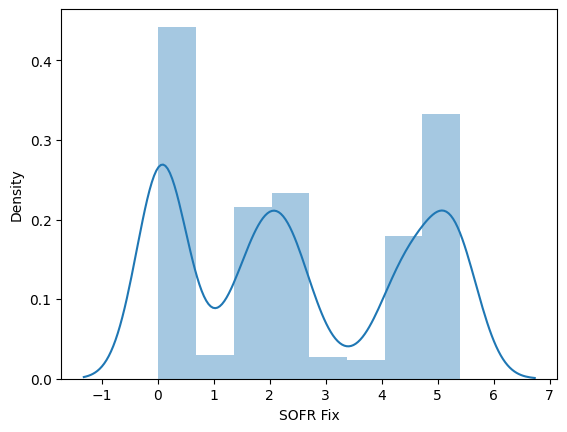

In [22]:
sns.distplot(df['SOFR Fix'])
print(df['SOFR Fix'].skew())

1.3881654049230205


C:\Users\Yash Singhal\AppData\Local\Temp\ipykernel_21064\1952875412.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['SOFR Volume'])


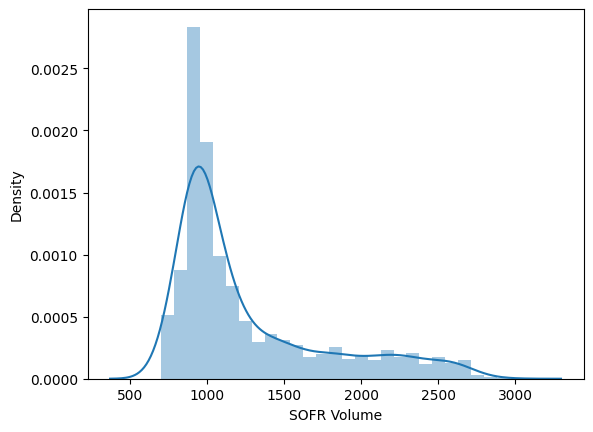

In [23]:
sns.distplot(df['SOFR Volume'])
print(df['SOFR Volume'].skew())

0.1510650118544129


C:\Users\Yash Singhal\AppData\Local\Temp\ipykernel_21064\626132318.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['DTCC Tsy'])


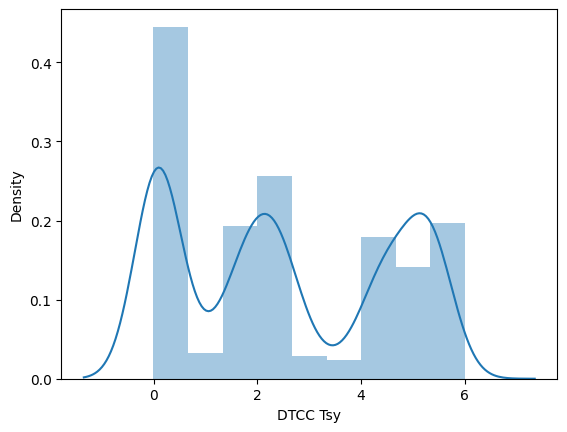

In [24]:
sns.distplot(df['DTCC Tsy'])
print(df['DTCC Tsy'].skew())

C:\Users\Yash Singhal\AppData\Local\Temp\ipykernel_21064\84510397.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['RRP Amt'])


0.8259880034161988


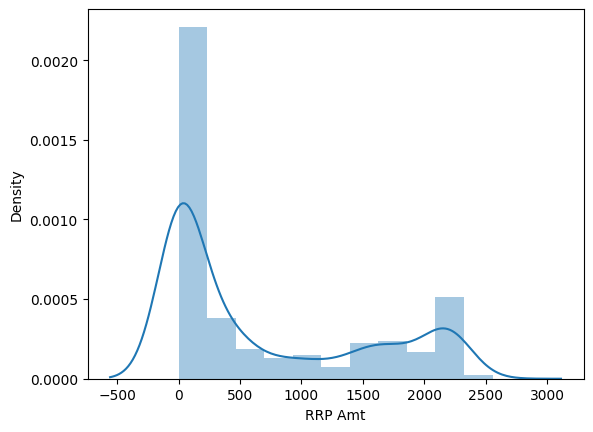

In [25]:
sns.distplot(df['RRP Amt'])
print(df['RRP Amt'].skew())

C:\Users\Yash Singhal\AppData\Local\Temp\ipykernel_21064\1637397520.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['TGA Balance'])


1.2099502707550547


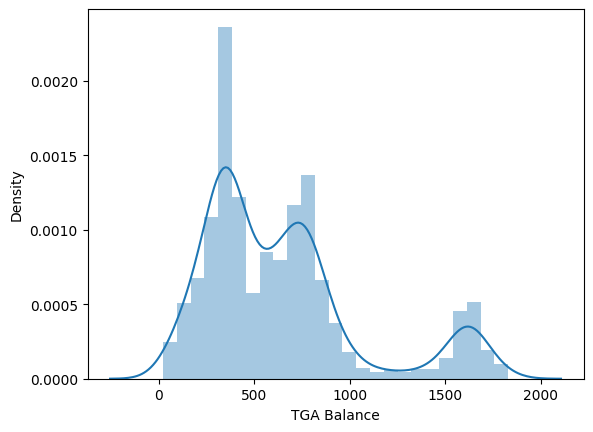

In [26]:
sns.distplot(df['TGA Balance'])
print(df['TGA Balance'].skew())

In [27]:
n_total = len(df)
n_train = int(0.7 * n_total)
n_val = int(0.15 * n_total)
n_test = n_total - n_train - n_val  # ensures it sums to total

train_end_idx = n_train - 1
val_end_idx = n_train + n_val - 1

df_train = df.iloc[:train_end_idx + 1]
df_val = df.iloc[train_end_idx + 1:val_end_idx + 1]
df_test = df.iloc[val_end_idx + 1:]

In [28]:
df_test.head()

,SOFR Fix,SOFR Volume,DTCC Tsy,RRP Amt,TGA Balance,DFF,day,year,month,month_sin,month_cos,dow,dow_sin,dow_cos,weekofyear,quarter,month_end_flag,quarter_end_flag,year_end_flag
1591,5.31,1816.0,5.346,486.434,795.161,4.83,10,2024,5,0.5,-0.866025,4,-0.433884,-0.900969,19,2,0,0,0
1592,5.31,1805.0,5.318,492.068,808.430,5.33,13,2024,5,0.5,-0.866025,0,0.000000,1.000000,20,2,0,0,0
1593,5.31,1838.0,5.348,468.344,805.661,5.33,14,2024,5,0.5,-0.866025,1,0.781831,0.623490,20,2,0,0,0
1594,5.31,1936.0,5.362,443.779,706.108,5.33,15,2024,5,0.5,-0.866025,2,0.974928,-0.222521,20,2,0,0,0
1595,5.31,2001.0,5.372,410.121,716.876,5.33,16,2024,5,0.5,-0.866025,3,0.433884,-0.900969,20,2,0,0,0


<Axes: ylabel='SOFR Fix'>

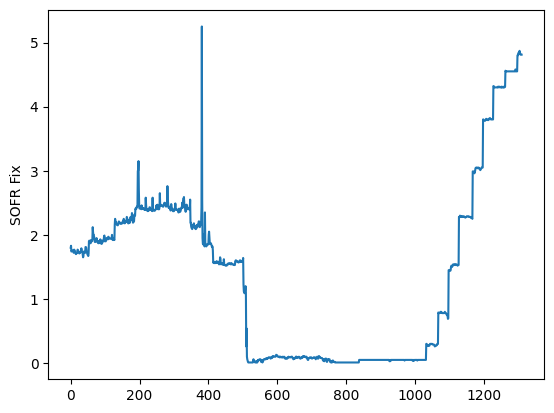

In [29]:
sns.lineplot(df_train['SOFR Fix'])

In [30]:
p=PowerTransformer(method='yeo-johnson')
cols_to_transform = ['SOFR Volume', 'RRP Amt', 'TGA Balance']

df_train[cols_to_transform] = p.fit_transform(df_train[cols_to_transform])
df_test[cols_to_transform] = p.transform(df_test[cols_to_transform])
df_val[cols_to_transform] = p.transform(df_val[cols_to_transform])

C:\Users\Yash Singhal\AppData\Local\Temp\ipykernel_21064\2120343100.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[cols_to_transform] = p.fit_transform(df_train[cols_to_transform])
C:\Users\Yash Singhal\AppData\Local\Temp\ipykernel_21064\2120343100.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[cols_to_transform] = p.transform(df_test[cols_to_transform])
C:\Users\Yash Singhal\AppData\Local\Temp\ipykernel_21064\2120343100.py:6: SettingWithCopyWarning: 
A value is trying to be set o

In [31]:
df_val.head()

,SOFR Fix,SOFR Volume,DTCC Tsy,RRP Amt,TGA Balance,DFF,day,year,month,month_sin,month_cos,dow,dow_sin,dow_cos,weekofyear,quarter,month_end_flag,quarter_end_flag,year_end_flag
1311,4.8,2.409333,4.846,1.267047,-2.186944,4.83,4,2023,11,-5.000000e-01,0.866025,5,-0.974928,-0.222521,44,4,0,0,0
1312,4.8,2.378792,4.822,1.267681,-2.502758,4.83,4,2023,12,-2.449294e-16,1.000000,0,0.000000,1.000000,49,4,0,0,0
1313,4.8,2.465310,4.855,1.269370,-2.299391,4.83,13,2023,4,8.660254e-01,-0.500000,3,0.433884,-0.900969,15,2,0,0,0
1314,4.8,2.170791,4.850,1.262861,-1.856821,4.83,14,2023,4,8.660254e-01,-0.500000,4,-0.433884,-0.900969,15,2,0,0,0
1315,4.8,2.582699,4.849,1.263159,-1.761394,4.83,17,2023,4,8.660254e-01,-0.500000,0,0.000000,1.000000,16,2,0,0,0


In [32]:
s=MinMaxScaler()

df_train_s=s.fit_transform(df_train)
df_test_s=s.transform(df_test)
df_val_s=s.transform(df_val)

df_train_s = pd.DataFrame(df_train_s, columns=df_train.columns, index=df_train.index)
df_val_s = pd.DataFrame(df_val_s, columns=df_val.columns, index=df_val.index)
df_test_s = pd.DataFrame(df_test_s, columns=df_test.columns, index=df_test.index)

In [33]:
df_train_s.columns

Index(['SOFR Fix', 'SOFR Volume', 'DTCC Tsy', 'RRP Amt', 'TGA Balance', 'DFF',
       'day', 'year', 'month', 'month_sin', 'month_cos', 'dow', 'dow_sin',
       'dow_cos', 'weekofyear', 'quarter', 'month_end_flag',
       'quarter_end_flag', 'year_end_flag'],
      dtype='object')

In [34]:
look_back = 1

def build_sequences(df, target_col='SOFR Fix', exo_cols=None, look_back=1):
    target = df[target_col].values

    exo = df[exo_cols].values

    X_seq, X_exo, y = [], [], []

    for i in range(look_back, len(df)):
        # Sequence of past 'look_back' SOFR Fix values
        seq = target[i-look_back:i].reshape(-1, 1)  # shape (look_back, 1)
        # Exogenous features on day t (current day)
        exo_features = exo[i]
        # Target SOFR Fix on day t
        y_target = target[i]

        X_seq.append(seq)
        X_exo.append(exo_features)
        y.append(y_target)

    return np.array(X_seq), np.array(X_exo), np.array(y)

# Define which columns are exogenous features
exo_cols = ['SOFR Volume', 'DTCC Tsy', 'RRP Amt', 'TGA Balance', 'DFF',
       'day', 'year', 'month', 'month_sin', 'month_cos', 'dow', 'dow_sin',
       'dow_cos', 'weekofyear', 'quarter', 'month_end_flag',
       'quarter_end_flag', 'year_end_flag']

# For training data
X_seq_train, X_exo_train, y_train = build_sequences(df_train_s, exo_cols=exo_cols)

# For validation data
X_seq_val, X_exo_val, y_val = build_sequences(df_val_s, exo_cols=exo_cols)

# For test data
X_seq_test, X_exo_test, y_test = build_sequences(df_test_s, exo_cols=exo_cols)

In [35]:
print("Train: X_seq:", X_seq_train.shape, "X_exo:", X_exo_train.shape, "y:", y_train.shape)
print("Validation: X_seq:", X_seq_val.shape, "X_exo:", X_exo_val.shape, "y:", y_val.shape)
print("Test: X_seq:", X_seq_test.shape, "X_exo:", X_exo_test.shape, "y:", y_test.shape)

Train: X_seq: (1310, 1, 1) X_exo: (1310, 18) y: (1310,)
Validation: X_seq: (279, 1, 1) X_exo: (279, 18) y: (279,)
Test: X_seq: (281, 1, 1) X_exo: (281, 18) y: (281,)


In [36]:
input_seq = Input(shape=X_seq_train.shape[1:], name="sofr_sequence")
x = LSTM(64, activation="tanh", name="lstm_layer")(input_seq)
x = Dropout(0.3, name="dropout_seq")(x)

# 🔸 Exogenous branch input: static exogenous features at current day
input_exo = Input(shape=X_exo_train.shape[1:], name="exo_features")
y = Dense(32, activation="relu", name="dense_exo1")(input_exo)
y = Dropout(0.3, name="dropout_exo")(y)

# 🔸 Merge both branches
merged = Concatenate(name="merge")([x, y])
z = Dense(32, activation="relu", name="dense_merge1")(merged)
output = Dense(1, activation="linear", name="output")(z)

model = Model(inputs=[input_seq, input_exo], outputs=output)

# 🔸 Compile model
model.compile(optimizer="nadam", loss="mse", metrics=["mae"])

# 🔸 Print summary to check architecture
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sofr_sequence (InputLayer)    │ (None, 1, 1)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ exo_features (InputLayer)     │ (None, 18)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm_layer (LSTM)             │ (None, 64)                │          16,896 │ sofr_sequence[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_exo1 (Dense)            │ (None, 32)                │             608 │ exo_features[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_seq (Dropout)         │ (None, 64)                │               0 │ lstm_layer[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_exo (Dropout)         │ (None, 32)                │               0 │ dense_exo1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ merge (Concatenate)           │ (None, 96)                │               0 │ dropout_seq[0][0],         │
│                               │                           │                 │ dropout_exo[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_merge1 (Dense)          │ (None, 32)                │           3,104 │ merge[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output (Dense)                │ (None, 1)                 │              33 │ dense_merge1[0][0]         │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 20,641 (80.63 KB)

 Trainable params: 20,641 (80.63 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Callbacks to improve training
early_stopping = EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", patience=15, factor=0.5, verbose=1)

history = model.fit(
    [X_seq_train, X_exo_train], y_train,
    validation_data=([X_seq_val, X_exo_val], y_val),
    epochs=1000,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)


Epoch 1/1000
41/41 - 3s - 78ms/step - loss: 0.0887 - mae: 0.2277 - val_loss: 0.3102 - val_mae: 0.5508 - learning_rate: 0.0010
Epoch 2/1000
41/41 - 0s - 3ms/step - loss: 0.0330 - mae: 0.1425 - val_loss: 0.0616 - val_mae: 0.2412 - learning_rate: 0.0010
Epoch 3/1000
41/41 - 0s - 3ms/step - loss: 0.0131 - mae: 0.0891 - val_loss: 0.0021 - val_mae: 0.0358 - learning_rate: 0.0010
Epoch 4/1000
41/41 - 0s - 4ms/step - loss: 0.0058 - mae: 0.0583 - val_loss: 9.4458e-04 - val_mae: 0.0248 - learning_rate: 0.0010
Epoch 5/1000
41/41 - 0s - 3ms/step - loss: 0.0042 - mae: 0.0501 - val_loss: 7.0466e-04 - val_mae: 0.0197 - learning_rate: 0.0010
Epoch 6/1000
41/41 - 0s - 3ms/step - loss: 0.0037 - mae: 0.0447 - val_loss: 9.6090e-04 - val_mae: 0.0251 - learning_rate: 0.0010
Epoch 7/1000
41/41 - 0s - 3ms/step - loss: 0.0032 - mae: 0.0395 - val_loss: 0.0011 - val_mae: 0.0270 - learning_rate: 0.0010
Epoch 8/1000
41/41 - 0s - 3ms/step - loss: 0.0025 - mae: 0.0357 - val_loss: 0.0012 - val_mae: 0.0274 - learning_

In [40]:
# --- Predict on test set with current model ---
y_pred_norm_test = model.predict([X_seq_test, X_exo_test]).flatten()

# --- Undo normalization for predictions and actuals ---
dummy_pred_test = np.zeros((len(y_pred_norm_test), df_train.shape[1]))
dummy_actual_test = np.zeros((len(y_test), df_train.shape[1]))
sofr_idx = df_train.columns.get_loc("SOFR Fix")

dummy_pred_test[:, sofr_idx] = y_pred_norm_test
dummy_actual_test[:, sofr_idx] = y_test

pred_orig_test = s.inverse_transform(dummy_pred_test)[:, sofr_idx]
actual_orig_test = s.inverse_transform(dummy_actual_test)[:, sofr_idx]


# Predict normalized outputs on validation set
y_pred_norm_val = model.predict([X_seq_val, X_exo_val]).flatten()

# Undo normalization
dummy_pred_val = np.zeros((len(y_pred_norm_val), df_train.shape[1]))
dummy_actual_val = np.zeros((len(y_val), df_train.shape[1]))
dummy_pred_val[:, sofr_idx] = y_pred_norm_val
dummy_actual_val[:, sofr_idx] = y_val

pred_orig_val = s.inverse_transform(dummy_pred_val)[:, sofr_idx]
actual_orig_val = s.inverse_transform(dummy_actual_val)[:, sofr_idx]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [41]:


mae_val = mean_absolute_error(actual_orig_val, pred_orig_val)
rmse_val = mean_squared_error(actual_orig_val, pred_orig_val)**0.5
mape_val = np.mean(np.abs((actual_orig_val - pred_orig_val) / actual_orig_val)) * 100
r2_val = r2_score(actual_orig_val, pred_orig_val)

print("🔹 Validation Metrics (original scale)")
print(f"MAE:  {mae_val:.4f}")
print(f"RMSE: {rmse_val:.4f}")
print(f"MAPE: {mape_val:.2f}%")
print(f"R²:   {r2_val:.4f}")


🔹 Validation Metrics (original scale)
MAE:  0.0571
RMSE: 0.0714
MAPE: 1.09%
R²:   0.7721


In [42]:


# --- Compute metrics on original scale ---
mae_test = mean_absolute_error(actual_orig_test, pred_orig_test)
rmse_test = mean_squared_error(actual_orig_test, pred_orig_test)**0.5
mape_test = np.mean(np.abs((actual_orig_test - pred_orig_test) / actual_orig_test)) * 100
r2_test = r2_score(actual_orig_test, pred_orig_test)
accuracy_test1 = np.mean(np.abs(actual_orig_test - pred_orig_test) / actual_orig_test < 0.01) * 100
accuracy_test5 = np.mean(np.abs(actual_orig_test - pred_orig_test) / actual_orig_test < 0.05) * 100

# --- Print metrics ---
print("\n🔹 Test Metrics (Original Scale)")
print(f"MAE:  {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAPE: {mape_test:.2f}%")
print(f"R²:   {r2_test:.4f}")
print(f"Pseudo-Accuracy (<1% error): {accuracy_test1:.2f}%")
print(f"Pseudo-Accuracy (<5% error): {accuracy_test5:.2f}%")



🔹 Test Metrics (Original Scale)
MAE:  0.0900
RMSE: 0.1124
MAPE: 1.86%
R²:   0.9347
Pseudo-Accuracy (<1% error): 31.32%
Pseudo-Accuracy (<5% error): 96.80%


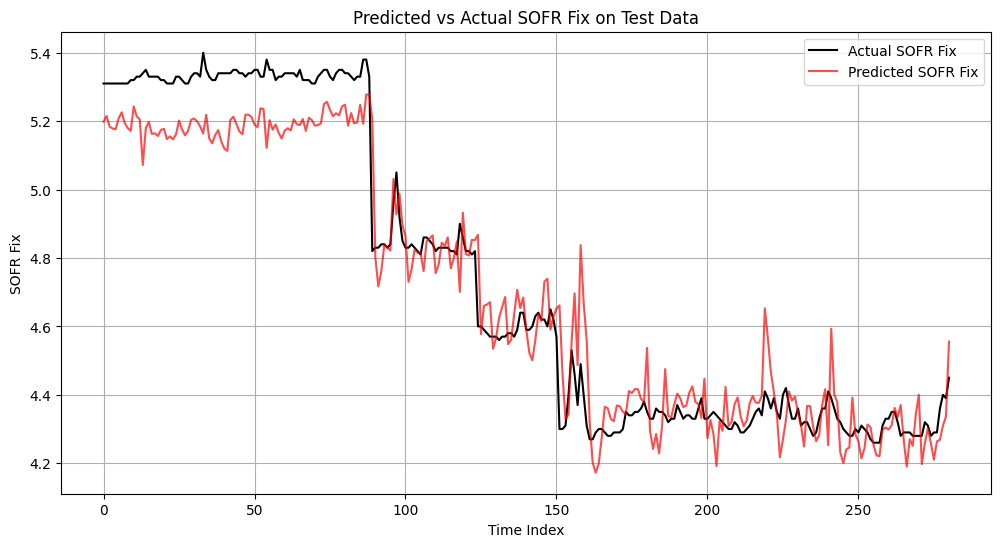

In [43]:

plt.figure(figsize=(12,6))
plt.plot(actual_orig_test, label="Actual SOFR Fix", color="black")
plt.plot(pred_orig_test, label="Predicted SOFR Fix", color="red", alpha=0.7)
plt.legend()
plt.title("Predicted vs Actual SOFR Fix on Test Data")
plt.xlabel("Time Index")
plt.ylabel("SOFR Fix")
plt.grid(True)
plt.show()


In [44]:
# --- Compute metrics ---
mae_test = mean_absolute_error(actual_orig_test, pred_orig_test)
rmse_test = mean_squared_error(actual_orig_test, pred_orig_test)**0.5
mape_test = np.mean(np.abs((actual_orig_test - pred_orig_test) / actual_orig_test)) * 100
r2_test = r2_score(actual_orig_test, pred_orig_test)
accuracy_test1 = np.mean(np.abs(actual_orig_test - pred_orig_test) / actual_orig_test < 0.01) * 100
accuracy_test5 = np.mean(np.abs(actual_orig_test - pred_orig_test) / actual_orig_test < 0.05) * 100

# --- Print metrics ---
print("\n🔹 Test Metrics (Original Scale)")
print(f"MAE:  {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")
print(f"MAPE: {mape_test:.2f}%")
print(f"R²:   {r2_test:.4f}")
print(f"Pseudo-Accuracy (<1% error): {accuracy_test1:.2f}%")
print(f"Pseudo-Accuracy (<5% error): {accuracy_test5:.2f}%")

# --- Print last predicted vs. actual value ---
print(f"\n🔹 Last Test Sample:")
print(f"Predicted SOFR Fix: {pred_orig_test[-1]:.4f}")
print(f"Actual SOFR Fix:    {actual_orig_test[-1]:.4f}")



🔹 Test Metrics (Original Scale)
MAE:  0.0900
RMSE: 0.1124
MAPE: 1.86%
R²:   0.9347
Pseudo-Accuracy (<1% error): 31.32%
Pseudo-Accuracy (<5% error): 96.80%

🔹 Last Test Sample:
Predicted SOFR Fix: 4.5555
Actual SOFR Fix:    4.4500
